# Hydrograph Development Notebooks: Overview of Methodology

Summary notebook demonstrating the methodology used to develop flood hydrographs for a given return period at gaged locations using historical instanteous data. Procedure and sample data based on the [Grand Rapids Michigan Test Cast](https://github.com/Dewberry-RSG/HydrologyTools/blob/master/documentation/ProofofConceptHydrologyStudies.pdf) 


*Follow the Test Case link for detailed information on description of events, plots, and data produced in this notebook.*

In [1]:
import os
from glob import glob
import numpy as np
import pandas as pd
from scipy.integrate import trapz, cumtrapz, simps

from importlib import reload
import utils; reload(utils)
from utils import *

%matplotlib inline

In [2]:
# Read in data
df = initialize_test_case()

**Read in USGS Gage Records**

04119000_00060_dv.tsv
04119000_00060_iv.tsv
04119000_00065_iv.tsv


### Comparison of historic flood hydrographs for the Grand River at Grand Rapids, MI (04119000)

**From Figure 2:**

**	USGS 04119000 GRAND RIVER AT GRAND RAPIDS, MI**

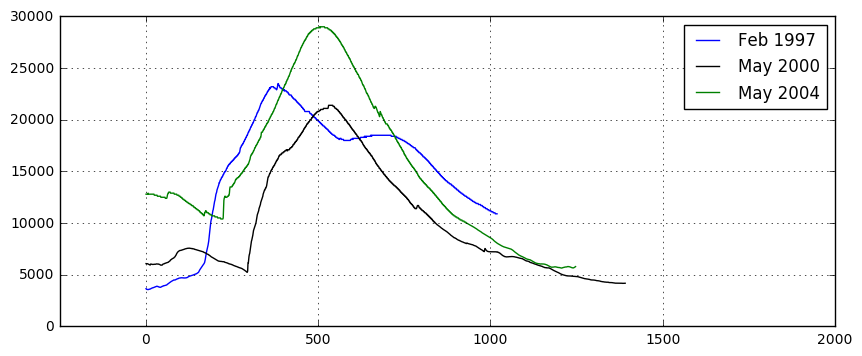

In [3]:
# Read in and adjust data to mimic ori
testcase = df[['04119000_00060_iv']].interpolate().copy()
storm1 = testcase['1997-02-17 18:00':'1997-03-10'].values
storm2 = testcase['2000-05-12':'2000-06-09'].values
storm3 = testcase['2004-05-17':'2004-06-11'].values
f, ax = plt.subplots()
ax.plot(np.arange(0, len(storm1)),storm1 ,color = 'blue', label = 'Feb 1997')
ax.plot(np.arange(0, len(storm2)),storm2 ,color = 'black',label = 'May 2000')
ax.plot(np.arange(0, len(storm3)),storm3 ,color = 'green',label = 'May 2004')
ax.grid()
ax.legend()
ax.set_xlim(-250, 2000)
f.set_size_inches(10,4)

printbold('From Figure 2:')
printbold('\tUSGS 04119000 GRAND RIVER AT GRAND RAPIDS, MI')

#### The May 2004 flood hydrograph 
    The discharges were smoothed slightly for demonstration purposes. A smoother curve on the ascending limb is possible using the code (see commented section) however for this example additiona smoothing was not required.

**	Smoothed Curve**

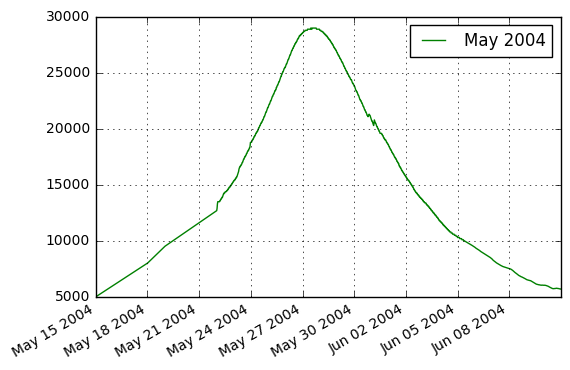

In [4]:
testcase = df[['04119000_00060_iv']].interpolate().copy()
storm = testcase['2004-05-15 00:00 ':'2004-06-10'].copy()

# Data during this period is set to null
null_start, null_stop = '2004-05-15 00:00','2004-05-22 00:00'
storm[null_start:null_stop ] = np.nan    

# Adjust intermediate values to smooth the curve
storm['2004-05-15 00:00':'2004-05-15 00:00'] = 5000
storm['2004-05-16 00:00':'2004-05-16 00:00'] = 6000
storm['2004-05-17 00:00':'2004-05-17 00:00'] = 7000
storm['2004-05-18 00:00':'2004-05-18 00:00'] = 8000
storm['2004-05-19 00:00':'2004-05-19 00:00'] = 9500
smooth_storm = storm.interpolate(how = 'spline', order=3) 

f, ax = plt.subplots()
ax.plot(smooth_storm,color = 'green',label = 'May 2004')
ax.grid()
ax.legend()

f.set_size_inches(6,4)
f.autofmt_xdate()
printbold('\tSmoothed Curve')

### Stretch the smooth curve to the estimated 1- and 0.2-percent chance flood hydrographs.

In [5]:
peak = float(storm3.max())
pct_1 = 50000  # Estimated 1% Chance Peak Flow (100yr event)
pct_02 = 65200 # Estimated 0.02% Chance Peak Flow (500yr event)

# Scale Factors
stretch_1pct = pct_1/peak 
stretch_02pct = pct_02/peak 

# Scale the May event
smooth_storm_resample = smooth_storm.resample('30T').mean()
smooth_storm_1pct = smooth_storm_resample*stretch_1pct
smooth_storm_02pct = smooth_storm_resample*stretch_02pct

print('Factors: \n','\t1 Percent\t{}'.format(stretch_1pct), '\n\t0.2 Percent\t{}'.format(stretch_02pct))

Factors: 
 	1 Percent	1.7241379310344827 
	0.2 Percent	2.2482758620689656


### Scale the Hydrographs & Plot

**The estimated 1- and 0.2-percent chance flood hydrographs for the Grand River**

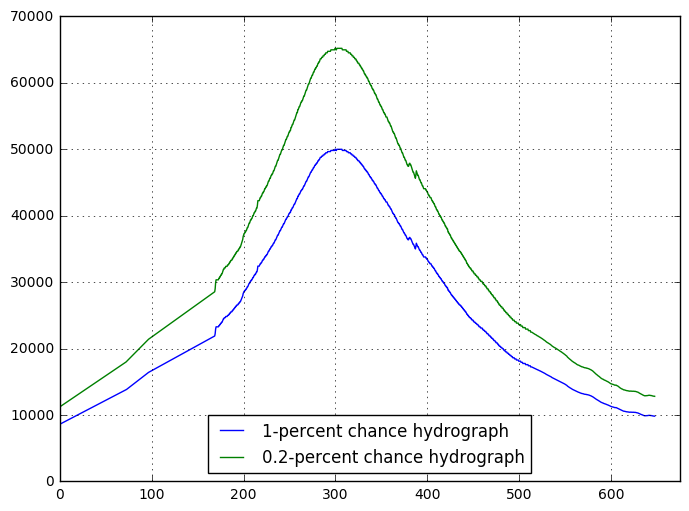

In [6]:
storm01 = smooth_storm_1pct.values
storm02 = smooth_storm_02pct.values
idx = np.arange(0, len(storm01))
f, ax = plt.subplots()
ax.plot(idx,storm01 ,color = 'blue', label = '1-percent chance hydrograph')
ax.plot(idx,storm02 ,color = 'green', label = '0.2-percent chance hydrograph')

ax.grid()
ax.legend(loc=0)
my_xticks = np.multiply(idx,100)
ax.set_xticklabels(my_xticks)
ax.set_xlim(0,1350)
f.set_size_inches(8,6)
printbold('The estimated 1- and 0.2-percent chance flood hydrographs for the Grand River')

### Verify approximate volumes under the curve

In [7]:
#--Calculate Volume to Verify Procedure
printbold('Volume Check')

may_volume = IntegrateHydrograph(smooth_storm, 4900.)
print('May Event\t',may_volume, 'inches' )
pct_1_volume = IntegrateHydrograph(smooth_storm_1pct, 4900.)
print('1 Percent\t', pct_1_volume, 'inches')
pct_02_volume = IntegrateHydrograph(smooth_storm_02pct, 4900.)
print('0.2 Percent\t',pct_02_volume, 'inches')

**Volume Check**

May Event	 2.95 inches
1 Percent	 5.09 inches
0.2 Percent	 6.64 inches


# END